In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torchvision
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor, Compose
from torchvision.datasets import MNIST
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit


import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

import seaborn as sns
from tqdm import tqdm

import torch.optim as optim
import torch
import torch.nn as nn


In [2]:
batch_size = 64
classes = list(range(10))


In [3]:
# Download the training dataset
trainset = MNIST(root='data/', train=True,
                      transform=ToTensor(), download=True)

# Download the test dataset
testset = MNIST(root='data/', train=False,
                     transform=ToTensor(), download=True)


In [4]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset,
                                                 [train_size, val_size])


In [5]:
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False)


In [6]:
len(trainset), len(valset), len(testset)

(48000, 12000, 10000)

In [7]:
labels = trainset.dataset.targets[trainset.indices].numpy()
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
_idx, subset_idx = next(split.split(trainset.indices, labels))
new_indices = list(np.array(trainset.indices)[subset_idx])
subset_sampler = SubsetRandomSampler(new_indices)

subset_loader = DataLoader(trainset.dataset, batch_size=64, sampler=subset_sampler)



In [8]:
len(labels), len(new_indices), len(subset_loader), len(trainset.indices)

(48000, 9600, 150, 48000)

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(
            in_channels=10, out_channels=20, kernel_size=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        self.fc1 = nn.Linear(in_features=20*5*5, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.flatten(start_dim=1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        x = self.softmax(x)
        return x
    

def train(model, train_loader, subset_loader, transform, val_loader, criterion, optimizer, epochs=1):

    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    # t = tqdm(total=epochs*(len(train_loader)+len(subset_loader)), desc="Epoch 0/{}".format(epochs))
    for epoch in range(epochs):  # loop over the dataset multiple times
        # t.set_description("Epoch {}/{}".format(epoch, epochs))
        # t.refresh()
        running_loss = 0.0
        correct = 0
        
        for i, (inputs, labels) in enumerate(subset_loader, 0):
            inputs = transform(inputs)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            outputs = torch.argmax(outputs, dim=1)
            correct += (outputs == labels).float().sum()

            running_loss += loss.item()
            # t.update(1)

        for i, (inputs, labels) in enumerate(train_loader, 0):

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            outputs = torch.argmax(outputs, dim=1)
            correct += (outputs == labels).float().sum()

            running_loss += loss.item()
            # t.update(1)
        

        loss = running_loss / (len(train_loader)+len(subset_loader))
        accuracy = 100*correct/(len(train_loader.dataset)+len(subset_loader)*64)
        train_loss.append(loss)
        train_acc.append(accuracy)
        correct = 0
        model.eval()
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader, 0):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                outputs = torch.argmax(outputs, dim=1)
                correct += (outputs == labels).float().sum()

                running_loss += loss.item()
            loss = running_loss / len(val_loader)
            accuracy = 100*correct/len(val_loader.dataset)
            val_loss.append(loss)
            val_acc.append(accuracy)

        model.train()
    # t.refresh()
    # t.close()

    print('Finished Training')
    return train_loss, val_loss, train_acc, val_acc


In [10]:
transforms_arr = [
    Compose([transforms.Resize((32, 32)),transforms.RandomCrop(28)]),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomRotation(10),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
]
transforms_names = [
    'Resize',
    'LeftRightFlip',
    'Rotation',
    'GaussianNoise',
]
transforms_combined = Compose(
    transforms_arr)
    
    

applying Resize
Finished Training


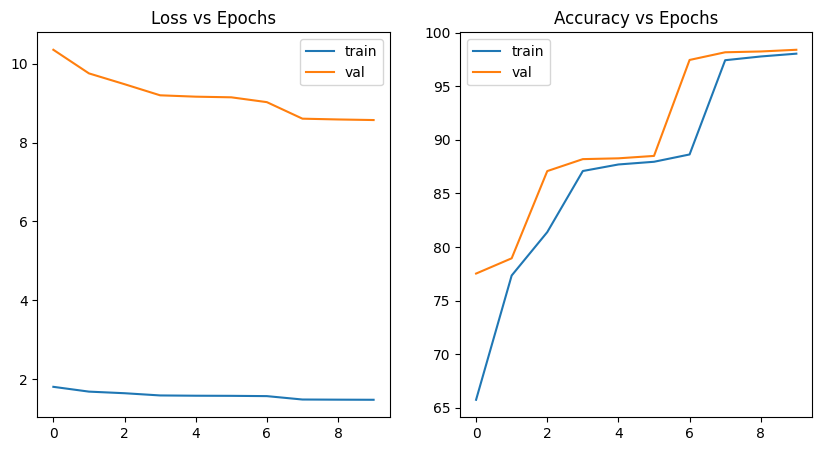

applying LeftRightFlip
Finished Training


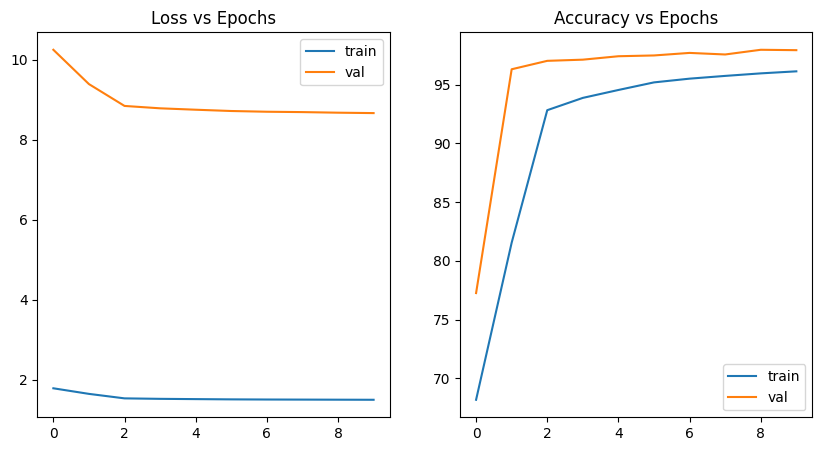

applying Rotation
Finished Training


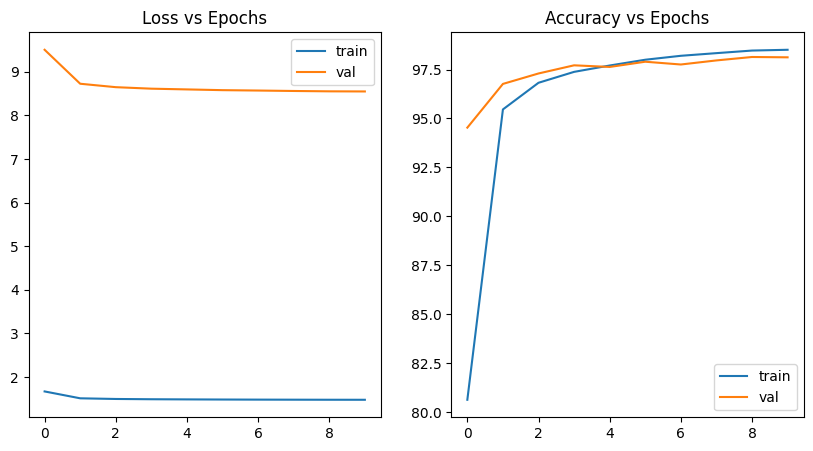

applying GaussianNoise
Finished Training


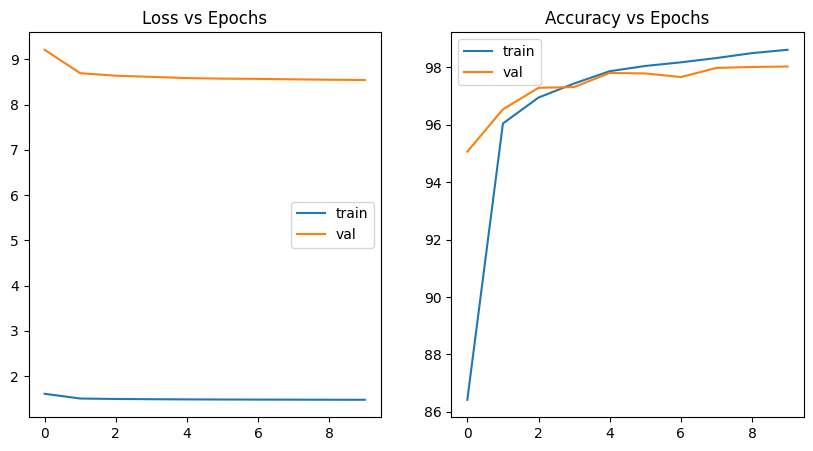

In [11]:
models = []
for transform, transform_name in zip(transforms_arr, transforms_names):
    print('applying', transform_name)
    model = CNN()
    models.append(model)
    
    train_loss, val_loss, train_acc, val_acc = train(model, train_loader, subset_loader, transform, val_loader, nn.CrossEntropyLoss(
    ), optim.Adam(model.parameters(), lr=0.001), epochs=10)
    torch.save(model.state_dict(),
               'models/model-a2-q3-{}.pt'.format(transform_name))
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
    axs[0, 0].plot(train_loss, label='train')
    axs[0, 0].plot(val_loss, label='val')
    axs[0, 0].set_title('Loss vs Epochs')
    axs[0, 0].legend()
    # axs[0, 0].show()

    axs[0, 1].plot(train_acc, label='train')
    axs[0, 1].plot(val_acc, label='val')
    axs[0, 1].set_title('Accuracy vs Epochs')
    axs[0, 1].legend()
    plt.show()


applying GaussianNoise
Finished Training


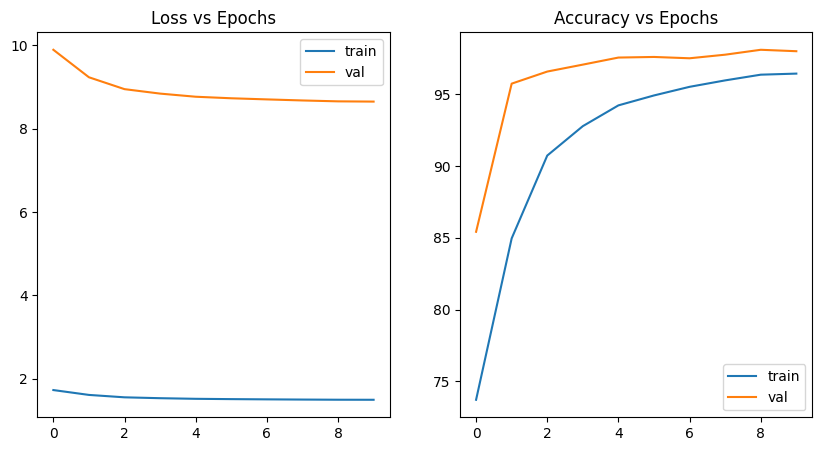

In [12]:

print('applying',transform_name)
model = CNN()
train_loss, val_loss, train_acc, val_acc = train(model, train_loader, subset_loader, transforms_combined, val_loader, nn.CrossEntropyLoss(
), optim.Adam(model.parameters(), lr=0.001), epochs=10)
torch.save(model.state_dict(),
           'models/model-a2-q3-combined.pt')
fig, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
axs[0, 0].plot(train_loss, label='train')
axs[0, 0].plot(val_loss, label='val')
axs[0, 0].set_title('Loss vs Epochs')
axs[0, 0].legend()
# axs[0, 0].show()


axs[0, 1].plot(train_acc, label='train')
axs[0, 1].plot(val_acc, label='val')
axs[0, 1].set_title('Accuracy vs Epochs')
axs[0, 1].legend()
plt.show()
        
        